# BI-LSTM Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_CharacterSwapping.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,label,text,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,0,0,2,@VirginAmerica What @dhepburn said.,35,what say,8,"['what', 'say']"
1,1,1,1,@VirginAmerica plus you've added commercials t...,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,2,2,2,@VirginAmerica I didn't today... Must mean I n...,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,3,3,0,@VirginAmerica it's really aggressive to blast...,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,4,4,0,@VirginAmerica and it's a really big bad thing...,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

Unnamed: 0.1              0
Unnamed: 0                0
label                     0
text                      0
length                    0
preprocessed_abstract    43
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [5]:
sentences = [sentence.split() for sentence in df['preprocessed_abstract']]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[ 6.8342316e-01,  6.4671272e-01,  1.1768763e+00, ...,
        -9.1367996e-01, -7.6893151e-02,  9.9506572e-02],
       [-4.9116847e-01,  1.3929319e+00,  9.0375841e-01, ...,
         3.2227490e-02,  1.7917667e-01,  1.4889693e-01],
       [-5.7922608e-01,  9.6614933e-01,  3.6193246e-01, ...,
        -1.3213280e+00, -1.7352085e-01, -1.2168401e-02],
       ...,
       [-3.0683577e-03,  9.7754570e-03,  1.0313574e-02, ...,
        -1.3657955e-02, -6.5076821e-03, -3.3413322e-05],
       [-1.3041286e-02,  6.6893664e-03,  1.6136028e-02, ...,
        -6.3431556e-03, -6.9987434e-03,  5.0279773e-03],
       [-1.3581026e-02,  1.1768084e-02,  2.3434283e-02, ...,
        -1.9129768e-02,  7.8096497e-03, -1.2009281e-02]], dtype=float32)

In [6]:
word_vectors.vectors.shape

(18600, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (21992,) (21992,)
Test data: (5499,) (5499,)


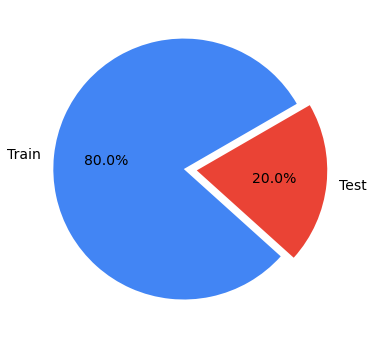

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[1416  243  350 ...    0    0    0]
 [ 384 1417   25 ...    0    0    0]
 [ 247  343 3851 ...    0    0    0]
 ...
 [   3   94   50 ...    0    0    0]
 [  98  112  117 ...    0    0    0]
 [   3   36   31 ...    0    0    0]]


In [10]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[  58  206 1150 ...    0    0    0]
 [  13    1    5 ...    0    0    0]
 [ 134  141 2994 ...    0    0    0]
 ...
 [ 640    1   51 ...    0    0    0]
 [   3 7310  175 ...    0    0    0]
 [  48  106  157 ...    0    0    0]]


##### 4)Model Architecture

In [11]:
model = Sequential()
model.add(Embedding(word_vectors.vectors.shape[0],100, input_length=max_length))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           1860000   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2095267 (7.99 MB)
Trainable params: 2095267 (7.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

##### 5) Training Model

In [14]:
history=model.fit(padded_docs_train, y_train, epochs=10, batch_size=64, validation_data=(padded_docs_test, y_test))
history

Epoch 1/10


344/344 [==============================] - 22s 52ms/step - loss: 0.6606 - accuracy: 0.7099 - val_loss: 1.4092 - val_accuracy: 0.4648
Epoch 2/10
344/344 [==============================] - 18s 51ms/step - loss: 0.3447 - accuracy: 0.8709 - val_loss: 1.7422 - val_accuracy: 0.4475
Epoch 3/10
344/344 [==============================] - 19s 55ms/step - loss: 0.2312 - accuracy: 0.9172 - val_loss: 1.9563 - val_accuracy: 0.4594
Epoch 4/10
344/344 [==============================] - 19s 56ms/step - loss: 0.1769 - accuracy: 0.9369 - val_loss: 2.2266 - val_accuracy: 0.4464
Epoch 5/10
344/344 [==============================] - 19s 56ms/step - loss: 0.1416 - accuracy: 0.9493 - val_loss: 2.3636 - val_accuracy: 0.4423
Epoch 6/10
344/344 [==============================] - 18s 53ms/step - loss: 0.1193 - accuracy: 0.9582 - val_loss: 2.6225 - val_accuracy: 0.4390
Epoch 7/10
344/344 [==============================] - 18s 53ms/step - loss: 0.1008 - accuracy: 0.9652 - val_loss: 2.8570 - val_accurac

##### 6) Finding Training and Testing Accuracy

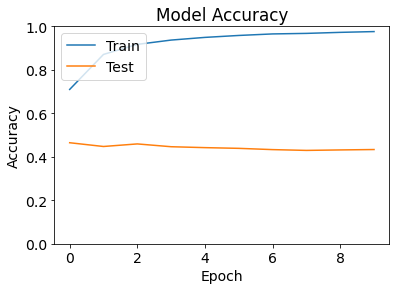

In [15]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
test_loss,test_acc=model.evaluate(padded_docs_test,y_test)
test_loss,test_acc

172/172 [==============================] - 2s 10ms/step - loss: 3.4979 - accuracy: 0.4335


(3.497850179672241, 0.43353337049484253)

##### 7) Compute and plot the confusion matrix for the three classes

In [17]:
predictions=model.predict(padded_docs_test)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

172/172 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

    negative       0.43      0.51      0.47      1835
     neutral       0.40      0.39      0.40      1828
    positive       0.47      0.40      0.43      1836

    accuracy                           0.43      5499
   macro avg       0.44      0.43      0.43      5499
weighted avg       0.44      0.43      0.43      5499



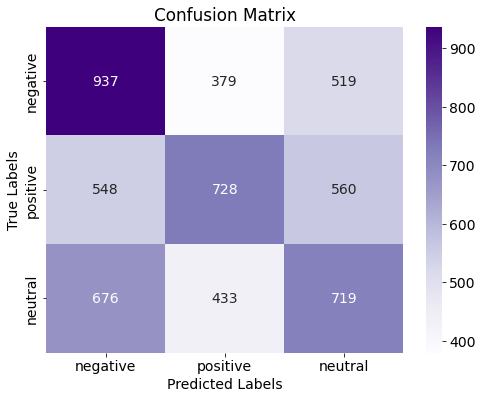

In [18]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [19]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.43359556 0.39988877 0.47272727]
Recall per class: [0.5106267  0.39332604 0.39651416]


In [20]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.43353336970358247
Macro F1 Score: 0.4322762811817202


In [21]:
result=pd.read_csv('BILSTMModelResults.csv')
result['CharacterSwapping_Dataset']=[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]
result[['Unnamed: 0','CharacterSwapping_Dataset']]

,Unnamed: 0,CharacterSwapping_Dataset
0,Training Accuracy,0.975991
1,Testing Accuracy,0.433533
2,Micro F1 Score,0.433533
3,Macro F1 Score,0.432276
4,Precision for Negative sentiment,0.433596
5,Precision for Positive sentiment,0.399889
6,Precision for Neutral sentiment,0.472727
7,Recall for Negative sentiment,0.510627
8,Recall for Positive sentiment,0.393326
9,Recall for Neutral sentiment,0.396514


In [22]:
result.to_csv('BILSTMModelResults.csv', index=False)